# Computational Methods in Economics

## Application: Job Search

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2019-01-27 21:34:58.335701


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import funapprox_cme as fa

In this notebook, we look at a different application of dynamic programming: modeling job search. More specifically, we look at the famous *McCall job search model* (McCall 1970). The exposition follows the section on quantecon.org; for more information, see https://lectures.quantecon.org/py/mccall_model.html.

In any period $t$, an infinitely-lived worker can be in one of two states, employed or unemployed. In the former case, she receives income $y_t = w$ (a wage), in the latter case she receives $y_t = b$, a fixed unemployment benefit. Her lifeftime utility is given by 

\begin{equation}
{\mathbb E} \sum_{t=0}^\infty \beta^t u(y_t)
\end{equation}

where $\beta$ is a discount factor.

In any period $t$, when the worker is employed, she loses her job with a given probability $\alpha$. In this case, she has no decision to take. In the other state, if the worker starts period $t$ being unemployed, she receives a job offer with probability $\gamma$. Moreover, the wage corresponding to the offer is a random variable, drawn from a uniform distribution $p$, with the minimum and maximum level given by $\underline{w}$ and $\bar{w}$, respectively. The worker then decides whether or not to accept the offer. If she accepts, she starts the following period being employed, while if she rejects, she remains unemployed.

How can we write the Bellman equation for this model? As in question 1, we actually need two Bellman equations, one for each state. Let $V(w)$ denote the value of being employed with wage $w$, and let $U$ denote the value of being unemployed. Then, the Bellman equation when being employed reads:

\begin{equation}
    V(w) = u(w) + \beta\left[(1 - \alpha) V(w) + \alpha U \right] 
\end{equation}

Again, note that there is no maximization problem on the right-hand side, since the worker has no decision to take: if she doesn't lose her job, she receives the same wage in the following period. 

When being unemployed, the Bellman equation reads:

\begin{equation}
    U = u(b) + \beta \left[ (1 - \gamma) U + \gamma \int_{\underline{w}}^{\bar{w}} \max\left\{V(w'), U\right\}    p(w') dw'\right] 
\end{equation}

Consider the two possible cases when starting period $t$ unemployed:

- With probability $(1 - \gamma)$, the worker does not receive a job offer and remains unemployed at the start of period $t + 1$.

- With probability $\gamma$, she receives a job offer, with a wage drawn from distribution $p$. In order to find the expected continuation value, since the wage is a continuous variable, we have to integrate over the range of possible outcomes $[\underline{w}, \bar{w}]$. For each wage rate $w'$, the worker would then decide whether to accept the offer (in this case, her continuation  value is $V(w')$) or to reject it, in which case she remains unemployed and has continuation value $U$. The decision is based on what choice gives the higher continuation value.

Note that the value $U$ does not depend on any wage rate, and hence is actually a constant, rather than a function.

Computationally, this problem is in some sense easier than the DP problem in the NGM that we have seen before, mainly because of the optimization problem. In the NGM, we have maximized the RHS of the Bellman equation over continuous variables (capital and labor). Here, the worker faces a discrete choice: accept or reject the job offer. Hence, we do not need to use derivative-based optimization algorithms like BFGS, instead maximization here means essentially comparing the outcomes under the two options.

If we treat $w$ as a continuous variable, we would still approximate the value function using Chebyshev polynomials, and then use a numerical integration approach to evaluate the integral on the right-hand side of the second Bellman equation. However, since we have not talked about numerical integration in this class, we use a simpler approach. We assume that the wage can only take a finite number $N$ of values; hence, it is a discrete random variable. For a uniform distribution, the probability of a given value $w_i$ is $1/N$. We can then approximate the integral with a simple sum:

\begin{equation}
    U = u(b) + \beta \left[ (1 - \gamma) U + \gamma \frac{1}{N} \sum_{i = 1}^N \max\left\{V(w_i), U\right\}\right] 
\end{equation}

Use dynamic programming to solve the model for $N = 60$ possible values for the wage, equally spaced in the interval $[10, 20]$ and the parameter values given below. Plot the value functions against the possible wage rates. At what wage level does the worker accept an offer (in other words, what is the so-called *reservation wage*)?

In [15]:
def u(c, nu):
    return (c**(1 - nu) - 1) / (1 - nu)

alpha = 0.2      # Job separation rate
beta = 0.98        # Discount factor
gamma = 0.7       # Job offer rate
b = 6.0      # Unemployment compensation
nu = 2.0       # Utility parameter

### Answer

#### Grid for wage rates

In [16]:
n = 60  # number of possible outcomes for wage
w_vec = np.linspace(10, 20, n)     # wages between 10 and 20
p_vec = np.ones(n) * 1/n

#### Value function iteration

In our iteration, we update the current guess for the value functions in the following way:

\begin{equation}
    V^{(it + 1)} (w) = u(w) + \beta \left[(1-\alpha)V^{(it)} (w) + \alpha U^{(it)} \right]
\end{equation}


\begin{equation}
    U^{(it + 1)} = u(b) +
    \beta (1 - \gamma) U^{(it)}
     + \beta \gamma \frac{1}{N} \sum_{i = 1}^N \max\left\{V^{(it)}(w_i), U^{(it)}\right\}
\end{equation}

In [17]:
V = np.ones(len(w_vec))  # Initial guess of V
V_new = np.ones(len(w_vec))    # To store updates to V
U = 1                        # Initial guess of U

it = 0
eps = 1
max_it = 1000

while eps > 1e-8 and it < max_it:
    it += 1
    ## loop over possible wage rates to find V(w)
    for idx, w in enumerate(w_vec):
        V_new[idx] = u(w, nu) + beta * ((1 - alpha) * V[idx] + alpha * U)
    ## compute new guess for U
    U_new = u(b, nu) + beta * (1 - gamma) * U + beta * gamma * np.sum(np.maximum(U, V) * p_vec)
    
    ## check for convergence
    eps_1 = np.linalg.norm(V_new - V))
    eps_2 = np.abs(U_new - U)
    eps = max(eps_1, eps_2)
    
    ## update current guess for value functions
    V[:] = V_new
    U = U_new

    
print(eps, it)    

9.9971160239e-09 907


#### Plot value functions

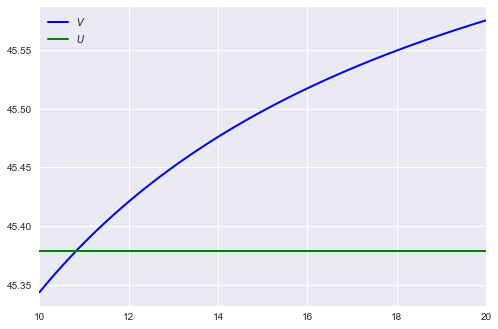

In [18]:
fig, ax = plt.subplots()
ax.plot(w_vec, V, 'b-', lw=2, label='$V$')
ax.plot(w_vec, U * np.ones(len(w_vec)), 'g-', lw=2, label='$U$')
ax.set_xlim(min(w_vec), max(w_vec))
ax.legend(loc='upper left')

#### Find reservation wage

The reservation wage is the smallest wage such $V(w) > U$: 

In [19]:
print("The reservation wage is {:.2f}.".format(w_vec[V > U][0], ) )

The reservation wage is 10.85.
